<a href="https://colab.research.google.com/github/NichaRoj/cubems-data-pipeline/blob/master/get_weather_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load extension to measure execution time
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=f317b2150586c7e640142999bf865b481391f7ec2835923138440305224b9e3e
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


## Import Weather Data
Let's import weather data from `wunderground`

In [2]:
import requests
from datetime import date
from datetime import timedelta
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

time: 414 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Specify date to pull data from
f_date = date(2020, 4, 19)
l_date = date(2020, 4, 23)
date_diff = l_date - f_date
print(date_diff)

4 days, 0:00:00
time: 2.23 ms


In [4]:
# Link to retrieve data from
url_template = 'https://www.wunderground.com/dashboard/pws/IBANGKOK26/table/{date}/{date}/daily'
# Columns from web scraping
column = ['Time','temp(degF)','dew(degF)','humidity(%)','Wind','windspeed(mph)','Gust','Pressure','Precip. Rate','Precip. Accum','UV','solar(w/m2)']
# Create empty dataframe
df = pd.DataFrame(columns=column)

#df for storing date that has incomplete value or no value
df_nodata = pd.DataFrame(columns=["Date", "Amount"])

# Loop to scrape data through specified days
j = 0
while j <= date_diff.days:
  current_date = f_date + timedelta(days=j)
  # Load website
  url = url_template.format(date=current_date)
  page = requests.get(url)
  # Scrape data from website
  soup = BeautifulSoup(page.content, "html.parser")
  table = soup.find_all("table", {"class": "history-table desktop-table"})
  len_df = len(df.index)
  try:
    # Understand how many rows of data we have.
    rows  = table[0].find_all('tr')
  except:
    # Execute if there is no weather data on this date
    print("No weather data on {}".format(current_date))
    df_nodata = df_nodata.append(pd.Series(data=[current_date, 0], index=df_nodata.columns), ignore_index=True)
    j += 1
  else:
    for i, row in enumerate(rows):
      cols = row.find_all('td')
      temp = []
      for col in cols:
        temp.append(col.text.strip())
      if i == 0 or i == 1:
        continue
      # Change the time from crawl data from the web to date + time
      temp[0] = "{date} {time}".format(date=current_date, time=temp[0])
      df = df.append(pd.Series(temp, index=df.columns), ignore_index=True)

    if len(df.index) - len_df != 288:
      df_nodata = df_nodata.append(pd.Series(data=[current_date, len(df.index)-len_df], index=df_nodata.columns), ignore_index=True)
    j += 1

time: 31 s


In [5]:
print('Scraped weather data')
df.info()
print('Dates that have no/incomplete data')
df_nodata.head()

Scraped weather data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time            1439 non-null   object
 1   temp(degF)      1439 non-null   object
 2   dew(degF)       1439 non-null   object
 3   humidity(%)     1439 non-null   object
 4   Wind            1439 non-null   object
 5   windspeed(mph)  1439 non-null   object
 6   Gust            1439 non-null   object
 7   Pressure        1439 non-null   object
 8   Precip. Rate    1439 non-null   object
 9   Precip. Accum   1439 non-null   object
 10  UV              1439 non-null   object
 11  solar(w/m2)     1439 non-null   object
dtypes: object(12)
memory usage: 135.0+ KB
Dates that have no/incomplete data


,Date,Amount
0,2020-04-21,287


time: 25.4 ms


After data has been imported, let's modify the dataframe to suit its purpose.

Since scraped data are considered `string` (or `object` for pandas dtypes), they must be changed to appropriate dtypes. Index must be set appropriately as well.

In [6]:
#Rearrange the format of each column
df['temp(degF)'] = df['temp(degF)'].str.split("\xa0").str[0]
df['dew(degF)'] = df['dew(degF)'].str.split("\xa0").str[0]
df['humidity(%)'] = df['humidity(%)'].str.split("\xa0").str[0]
df['windspeed(mph)']= df['windspeed(mph)'].str.split("\xa0").str[0]
df['solar(w/m2)']=df['solar(w/m2)'].str.split(" ").str[0]

# Drop unnecessary columns
df=df.drop(['Wind','Gust','Pressure','Precip. Rate','Precip. Accum','UV'], axis=1)

#Change to appropriate dtypes
df['Time']=pd.to_datetime(df['Time'])
df['temp(degF)'] = pd.to_numeric(df['temp(degF)'])
df['dew(degF)'] = pd.to_numeric(df['dew(degF)'])
df['humidity(%)'] = pd.to_numeric(df['humidity(%)'])
df['windspeed(mph)']= pd.to_numeric(df['windspeed(mph)'])
df['solar(w/m2)']= pd.to_numeric(df['solar(w/m2)'])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time            1439 non-null   datetime64[ns]
 1   temp(degF)      1439 non-null   float64       
 2   dew(degF)       1439 non-null   float64       
 3   humidity(%)     1439 non-null   int64         
 4   windspeed(mph)  1439 non-null   float64       
 5   solar(w/m2)     1439 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 67.6 KB


,Time,temp(degF),dew(degF),humidity(%),windspeed(mph),solar(w/m2)
0,2020-04-19 00:00:00,85.8,79.7,82,0.0,0
1,2020-04-19 00:05:00,85.7,79.6,82,0.0,0
2,2020-04-19 00:10:00,85.7,79.6,82,0.0,0
3,2020-04-19 00:15:00,85.7,79.6,82,0.0,0
4,2020-04-19 00:20:00,85.7,79.6,82,0.0,0


time: 213 ms


Since data in pipeline is collected every 15 minutes, we want the weather data to match that.

In [7]:
# Set index to DateTime
df_new = df.set_index('Time')
# Create DatetimeIndex
datetime_index = pd.date_range('{} 00:00:00'.format(f_date.strftime('%Y-%m-%d')), '{} 23:55:00'.format(l_date.strftime('%Y-%m-%d')), freq='5min')
df_new = df_new.reindex(datetime_index)
# Resample data to every 15 min
df_fifteen = df_new.resample('15T').mean()
df_fifteen.info()
df_fifteen.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2020-04-19 00:00:00 to 2020-04-23 23:45:00
Freq: 15T
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp(degF)      480 non-null    float64
 1   dew(degF)       480 non-null    float64
 2   humidity(%)     480 non-null    float64
 3   windspeed(mph)  480 non-null    float64
 4   solar(w/m2)     480 non-null    float64
dtypes: float64(5)
memory usage: 22.5 KB


,temp(degF),dew(degF),humidity(%),windspeed(mph),solar(w/m2)
2020-04-19 00:00:00,85.733333,79.633333,82.000000,0.0,0.0
2020-04-19 00:15:00,85.666667,79.566667,82.000000,0.0,0.0
2020-04-19 00:30:00,85.566667,79.466667,82.000000,0.0,0.0
2020-04-19 00:45:00,85.433333,79.433333,82.333333,0.0,0.0
2020-04-19 01:00:00,85.266667,79.266667,82.333333,0.0,0.0


time: 53.8 ms


## Explore Data
Let's explore data and see if there is any missing values.

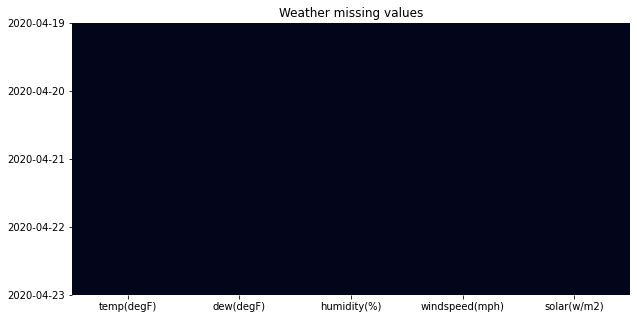

time: 330 ms


In [8]:
# The pink color indicates missing values
num_ticks = date_diff.days + 1 # tick number for Y-axis
date_range = pd.date_range(start=f_date, end=l_date).to_pydatetime().tolist()
date_range = list(map(lambda x: x.strftime('%Y-%m-%d'), date_range))

plt.figure(figsize = (10, 5))
ax = sns.heatmap(df_fifteen.isnull(), cbar=False, yticklabels=date_range)
ax.set_yticks(np.linspace(0, len(df_fifteen), num_ticks, dtype=np.int))
ax.set_title('Weather missing values')
plt.show()

Since there's no missing data in this case, no measures is taken. However, if there's missing data, they should be removed or replaced appropriately.

Next, let's try plotting some graphs.

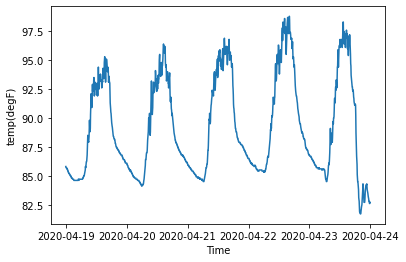

time: 337 ms


In [9]:
# Plot the graph
sns.lineplot(x='Time', y='temp(degF)', data=df)

Since we are not Americans, let's recalculate temperature to degree Celsius and plot the graph again.

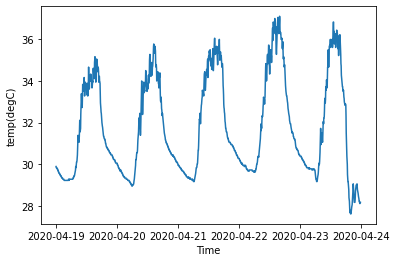

time: 354 ms


In [12]:
# Calculate temperature in Celsius
df['temp(degC)'] = df.apply(lambda row: (row['temp(degF)'] - 32)*5/9, axis=1)
# Plot the graph
sns.lineplot(x='Time', y='temp(degC)', data=df)